# *Lecture 16*

# Partial Differential Equations: Application to Heat Flow


| |
|:---:|
|Selected Content [From **COMPUTATIONAL PHYSICS**, 3rd Ed, 2015](http://physics.oregonstate.edu/~rubin/Books/CPbook/index.html) <br>RH Landau, MJ Paez, and CC Bordeianu (deceased) <br>Copyrights: <br> [Wiley-VCH, Berlin;](http://www.wiley-vch.de/publish/en/books/ISBN3-527-41315-4/) and [Wiley & Sons, New York](http://www.wiley.com/WileyCDA/WileyTitle/productCd-3527413154.html)<br>  R Landau, Oregon State Unv, <br>MJ Paez, Univ Antioquia,<br> C Bordeianu, Univ Bucharest, 2015.<br> Support by National Science Foundation.|

## Recap of Solution for Laplace's Equation in Polar Coordinates

We assumed that the indices were written for grid points $(r_i, \theta_j)$.

$$\begin{align}
\frac{\partial^2 U}{\partial r^2} &= \frac{U_{i-1,j} - 2U_{i,j} + U_{i+1,j}}{(\Delta r)^2} \\
\frac{1}{r^2} \frac{\partial^2 U}{\partial \theta^2} &= \frac{1}{r_i^2} \frac{U_{i,j-1} - 2U_{i,j} + U_{i,j+1}}{(\Delta \theta)^2} \\
\frac{1}{r} \frac{\partial U}{\partial r} &= \frac{1}{r_i} \frac{U_{i+1,j} - U_{i-1,j}}{2\Delta r} \\
\end{align}$$

But those are not the formulae we need for the stepping.  Now we need to solve for $U_{i,j}$:

$$\left( \frac{2}{(\Delta r)^2} + \frac{2}{r^2 (\Delta \theta)^2} \right) U_{i,j} = 
\frac{U_{i-1, j} + U_{i+1,j}}{(\Delta r)^2} + \frac{U_{i, j-1} + U_{i, j+1}}{r_1^2 (\Delta \theta)^2}
+ \frac{U_{i+1,j} - U_{i-1, j}}{2r_i \Delta r}$$

$$U_{i,j} = \left( \frac{2}{(\Delta r)^2} + \frac{2}{r^2 (\Delta \theta)^2} \right)^{-1} 
\left[ \frac{U_{i-1, j} + U_{i+1,j}}{(\Delta r)^2} + \frac{U_{i, j-1} + U_{i, j+1}}{r_1^2 (\Delta \theta)^2}
+ \frac{U_{i+1,j} - U_{i-1, j}}{2r_i \Delta r}\right]$$

Remember that the values "wrap around" the cylinder in $\theta$ but not in $r$.

The treatment of the $r=0$ point and its neighbors can be tricky.
In the following example, we set the conditions at $r=0$ and its neighbors by hand, and then we skip the iteration for the point(s) with $r=0$.

<IPython.core.display.Javascript object>


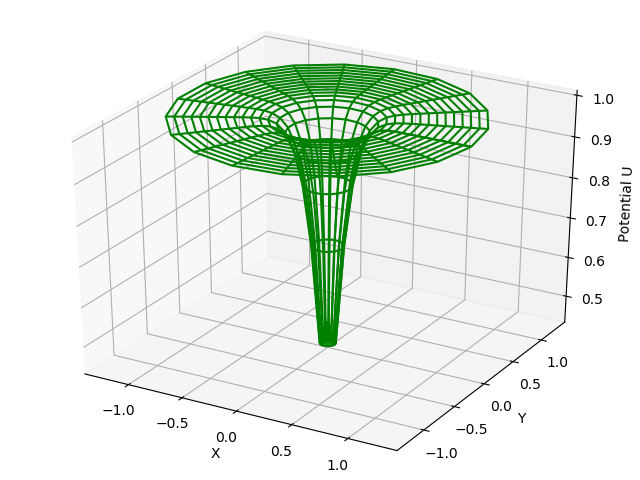

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

Nmax = 20
Niter = 10
V = np.ones((Nmax, Nmax))   

(r, r_step) =         np.linspace(0, 1.25, Nmax, retstep=True)
(theta, theta_step) = np.linspace(0, 2*np.pi, Nmax, retstep=True)
R, P = np.meshgrid(r, theta)

for k in range(0, Nmax): 
    V[Nmax-1,k] = 1.0       # fixed potential at boundary
    V[1,k] = 0.0            # fixed potential near center
    V[0,k] = 0.5            # fixed potential at r=0
    
for iter in range(Niter):   # iterations over algorithm
    #print(V)
    old_V = V.copy()
    for i in range(1, Nmax-1):   
        denom = 2./pow(r_step,2) + 2./pow(r[i],2)/pow(theta_step,2)
        j = 0
        V[i,j] = ((old_V[i-1,j]+old_V[i+1,j])/pow(r_step,2) + 
                  (old_V[i+1,j]-old_V[i-1,j])/r[i]/(2*r_step) + 
                  (old_V[i,-1]+old_V[i,j+1])/pow(r[i],2)/pow(theta_step,2))/denom
        for j in range(1,Nmax-1):
            V[i,j] = ((old_V[i-1,j]+old_V[i+1,j])/pow(r_step,2) + 
                      (old_V[i+1,j]-old_V[i-1,j])/r[i]/(2*r_step) + 
                      (old_V[i,j-1]+old_V[i,j+1])/pow(r[i],2)/pow(theta_step,2))/denom
        j = Nmax-1
        V[i,j] = ((old_V[i-1,j]+old_V[i+1,j])/pow(r_step,2) + 
                  (old_V[i+1,j]-old_V[i-1,j])/r[i]/(2*r_step) + 
                  (old_V[i,j-1]+old_V[i,0])/pow(r[i],2)/pow(theta_step,2))/denom

x = range(0, Nmax)
y = range(0, Nmax)
X, Y = np.meshgrid(x,y)          

def functz(V):                                  # Function returns V(x, y)
    z = V[X,Y]                        
    return z

Z = functz(V)
              
# Transform back to rectangular coordinates for plotting
X, Y = R*np.cos(P), R*np.sin(P)

fig = plt.figure()                              # Create figure
ax = Axes3D(fig)                                # plot axes
ax.plot_wireframe(X, Y, Z, color = 'g')         
ax.set_xlabel('X')                              # label axes
ax.set_ylabel('Y')
ax.set_zlabel('Potential U')
plt.show()  

# Introduction to Heat Equation

In this lecture we will explore the heat equation in a 1-dimensional system (also called the diffusion equation).  The basic form is

$$\frac{\partial u}{\partial t} - k \frac{\partial^2 u}{\partial x^2} = 0, \quad k>0$$

There are two reasons for exploring the heat equation at this point:
* It is a good example of a parabolic PDE, as opposed to the elliptic (Laplace) or hyperbolic (wave) equations that we cover elsewhere.
* The techniques developed for this simple case will be useful in finding solutions to the *time-dependent* Schrödinger equation.

## Physics Derivation

Consider a mass with points at different temperatures $T(x,t)$.

The "total heat energy" in the mass depends on the material's specific heat $C$, its mass density $\rho$, and its volume:

$$Q(t) = \int_V C\rho({\bf x}) T({\bf x}, t) d{\bf x}$$ 

The rate of change of heat in the material is therefore given by 

$$\frac{\partial Q}{\partial t} = \int_V C\rho({\bf x}) \frac{\partial T({\bf x}, t)}{\partial t} d{\bf x}$$ 

If $\frac{\partial Q}{\partial t} < 0$, then there must be a heat flow out of the system.

In one dimension, the heat flow must of course be along $x$, but in general it would be across the system boundary (surface).
We can write the heat flow $\bf H$ in general at any point as 

$$\textbf{H} =- K \mathbf{\nabla} T(\mathbf{x}, t), \quad K>0$$

The heat flow is opposite the temperature gradient (steepest ascent).
The proportionality constant $K$ is the thermal conductivity of the material.

Now, the total heat flow and change of heat must be equal, because the heat flow is causing the change in heat.
But $\bf H$ is a vector flow, and $\partial Q/ \partial t$ is a scalar.

We need to integrate the heat flow over the surface to find the total heat rate of change.
A positive heat flow out corresponds to a negative rate of change, so the sign of $\bf H$ is flipped.

$$\int_V C\rho \frac{\partial T}{\partial t} d{\bf x} = \oint_S K {\bf \nabla} T \cdot n dS$$

To compare these two integrals, we first convert the right-hand side to a volume integral using the divergence theorem:

$$\int_V C\rho \frac{\partial T}{\partial t} d{\bf x} = \int_V {\bf \nabla} \cdot (K{\bf \nabla}T) d{\bf x}$$

Since the integrals are over the same volume, we can conclude that the integrands must be equal everywhere.

$$\frac{\partial T({\bf x},t)}{\partial t} = \frac{K}{C\rho} \nabla^2 T({\bf x},t)$$

This is the heat equation in multiple dimensions.
For the simple case of one dimension, the equation is

$$\frac {\partial T(x,t)}{\partial t} = \frac{K}{C\rho}
\frac{\partial ^2 T(x,t)}{\partial x^2}$$

(Check this against the general form above.)

There are infinitely many solutions to this equation, given the physical properties, and we will need boundary conditions in order to specify a unique solution.

A typical boundary condition is that the surface (or end, in 1-D) is held at a constant temperature.
An arbitrary initial condition ($T(x,0)=0$, for example) can be used to get things started.

# Numerical Solution to Heat Equation

The usual approach to solving a general PDE is to approximate the differential equation with a finite difference equation.
We will try that technique again here.
We will pay special attention to the stability of the solution, since the orders of the two derivatives are different, unlike Laplace's equation.

As we did with Laplace’s equation, we discretize space and time on a lattice
and solve for $T(x_i, t_j)$ on the lattice sites.
The main difference is that we do **not** know the $T$ values at the bottom of the lattice for large $t$ values.
We will assume that we know the temperatures for some early time $t$, so that we can get the solution started.
Since we do not even have a guess for the solution at all $x$ and $t$, we will have to develop a **stepping method** instead of an iterative method.
The stepping method in time is similar to the Euler method in 1 dimension. 

It is natural that we **step forward in time at each position**.
We expect that the points adjacent to the position will affect the temperature at the next time step.

With only one row of times to
start with, we use a forward-difference approximation for the time
derivative of the temperature:

$$\frac{\partial T(x,t)}{\partial t} \simeq \frac{T(x,t+\Delta t)-
T(x,t)}{\Delta t}$$

We can do better with the spatial derivatives
because we know the spatial variation of the temperature along the
entire top row (initial condition) and the left and right sides (boundary conditions).
As we did with the Laplace equation, we first use the more accurate
"central-difference" (aka midpoint) approximation for the space derivative:

$$
\frac{\partial^2 T(x,t)}{\partial x^2} \simeq \frac{T(x +\Delta
x,t) -2 T(x,t) +T(x-\Delta x,t)}{(\Delta x)^2}$$

Then we can use these approximations instead of the derivatives to write an approximate heat difference equation

$$\frac{T(x,t+ \Delta t)-T(x,t)}{\Delta t} = \frac{K}{C\rho}
\frac{T(x+\Delta x,t) -2 T(x,t)+T(x-\Delta x,t) }{(\Delta
x)^2}$$

The final step is to rewrite the equation in terms of the points on the $(i,j)$ discrete grid.

$$
 T_{i,j+1} = T_{i,j}+ \eta
\left[T_{i+1,j}-2T_{i,j}+T_{i-1,j}\right], \quad \eta  = \frac{K
\Delta t}{C\rho (\Delta x)^2}$$

This is obviously an *explicit* form because it uses the points from a previous time step $t_{j}$ to find the current value at time $t_{j+1}$.

<img src="Figures/Figure_20.2.png" width="50%">

(By the way, you may have noticed a change in the notation.
Instead of the $T_i^{(j)}$ notation we used in the past with *iteration*, we are using $T_{i,j}$ because time is treated as a dimension on the grid.)

Our textbook describes this algorithm as the "*leapfrog* algorithm," but I don't think this is the usual understanding of "leapfrog."
In the usual leapfrog algorithm, the velocity and position updates are interleaved: position is updated from $t$ to $t + h$ and velocity is updated from $t-h/2$ to $t+h/2$.
Our example does update the "position" ($T$) for times $t$ to $t + h$, but it does not treat the "velocity" at all.
Maybe it is a "half-leapfrog" after all.

In the following example, we keep only the two latest arrays of $T$ values in the calculation: one for $t_{j}$ and one for $t_{j+1}$.
This trick reduces the memory needed for the calculation.
We keep a separate `Tpl` array copy for plotting purposes.

Initially the bar of length 1 meter is at a uniform
temperature of 100 C, and then both ends are placed in contact with ice
water at 0 C.

Working, wait for figure...
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


<IPython.core.display.Javascript object>


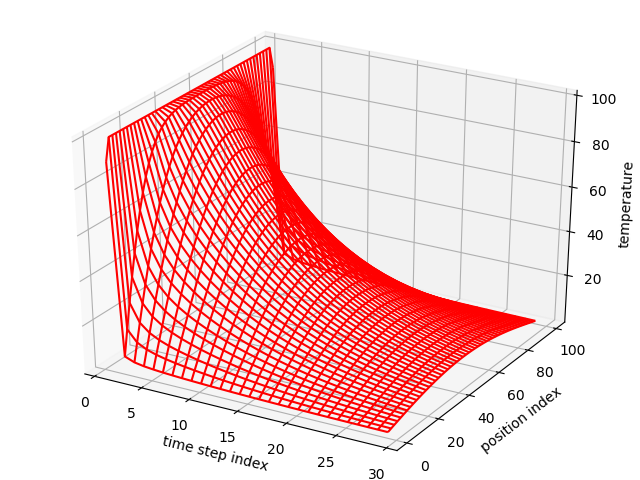

finished


In [9]:
""" From "COMPUTATIONAL PHYSICS", 3rd Ed
    by RH Landau, MJ Paez, and CC Bordeianu
    Copyright Wiley-VCH Verlag GmbH & Co. KGaA, Berlin;  Copyright R Landau,
    Oregon State Unv, MJ Paez, Univ Antioquia, C Bordeianu, Univ Bucharest, 2015.
    Support by National Science Foundation"""

# EqHeat.py: solves heat equation via finite differences, 3-D plot
% matplotlib notebook 
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D 

Nx = 101
Nt = 30000    
Dx = 0.03     
Dt = 1.0                                                              
KAPPA = 210. # conductivity
SPH = 900.   # specific heat
RHO = 2700.  # density
T = np.zeros((Nx, 2))
Tpl = np.zeros((Nx, 31))  
                                     
print("Working, wait for figure...")

for ix in range (1, Nx - 1):  T[ix, 0] = 100.0  # Initial T
T[0,0] = 0. 
T[0,1] = 0.                           # 1st & last T = 0
T[Nx-1,0] = 0.
T[Nx-1,1] = 0.
cons = KAPPA/(SPH*RHO)*Dt/(Dx*Dx)
m = 1

for t in range (1, Nt):                                  
   for ix in range (1, Nx - 1):                       
      T[ix, 1] = T[ix, 0] +  cons*(T[ix+1, 0] + T[ix-1, 0] - 2.*T[ix,0])                                                        
   if t==1 or t%1000 == 0:         # print and plot progress every 1000 steps
        for ix in range (1, Nx - 1, 2): 
            Tpl[ix, m] = T[ix, 1]  # save values for plotting
        print(m)   
        m = m + 1                        
   for ix in range (1, Nx - 1):
      T[ix, 0] = T[ix, 1] 
x = list(range(1, Nx - 1, 2))         # Plot alternate x pts, for clarity
y = list(range(1, 30))                       
X, Y = plt.meshgrid(x, y)                       

def functz(Tpl):                            
    z = Tpl[X, Y]       
    return z

Z = functz(Tpl)              
fig = plt.figure()                                          # Create figure
ax = Axes3D(fig)                                              
ax.plot_wireframe(Y, X, Z, color = 'r')                    
ax.set_xlabel('time step index')                                     
ax.set_ylabel('position index')
ax.set_zlabel('temperature')
plt.show()                               
print("finished")


It looks like the cold reservoirs on both ends of the bar are doing their job: the entire bar cools down toward a constant temperature $T=0$.
Try running the simulation for a longer time and see if all points eventually reach $T=0$.

## Stability Analysis

The parameter $\eta$ controls the change of $T$ as time steps from $t_j$ to $t_{j+1}$.

$$\eta  = \frac{K\Delta t}{C\rho (\Delta x)^2}$$

What is especially interesting for us is the ratio $\Delta t/(\Delta x)^2$, simply because we can control that!

Let's repeat the calculation with different step values and see how the solution evolves:
* Dx = 0.03, Dt = 1.0
* Dx = 0.01, Dt = 1.0
* Dx = 0.003, Dt = 1.0
* Dx = 0.03, Dt = 2.0
* Dx = 0.03, Dt = 10.0

Working, wait for figure...
constant = 0.09602194787379972
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


<IPython.core.display.Javascript object>


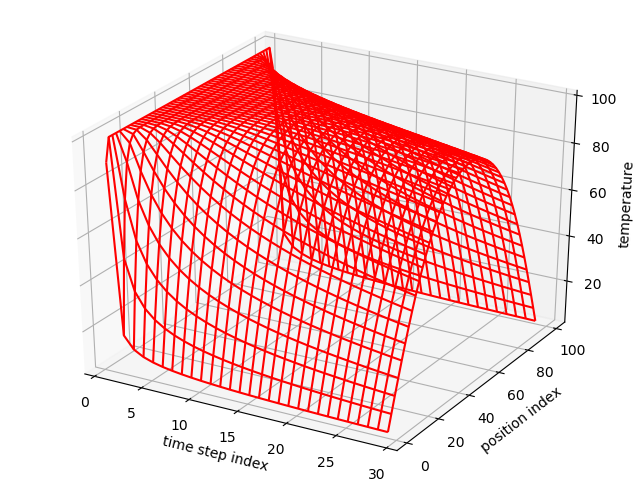

finished


In [11]:
""" From "COMPUTATIONAL PHYSICS", 3rd Ed
    by RH Landau, MJ Paez, and CC Bordeianu
    Copyright Wiley-VCH Verlag GmbH & Co. KGaA, Berlin;  Copyright R Landau,
    Oregon State Unv, MJ Paez, Univ Antioquia, C Bordeianu, Univ Bucharest, 2015.
    Support by National Science Foundation"""

# EqHeat.py: solves heat equation via finite differences, 3-D plot
% matplotlib notebook 
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D 

Nx = 101
Nt = 3000     
Dx = 0.03     
Dt = 1.0                                                             
KAPPA = 210.
SPH = 900.
RHO = 2700.
T = np.zeros( (Nx, 2) )
Tpl = np.zeros( (Nx, 31) )  
                                     
print("Working, wait for figure...")

for ix in range (1, Nx - 1):  T[ix, 0] = 100.0;
T[0,0] = 0.
T[0,1] = 0.
T[Nx-1,0] = 0.
T[Nx-1,1] = 0.
cons = KAPPA/(SPH*RHO)*Dt/(Dx*Dx)
print('constant =', cons)
m = 1

for t in range (1, Nt):                                  
   for ix in range (1, Nx - 1):                       
      T[ix, 1] = T[ix, 0] +  cons*(T[ix+1, 0] + T[ix-1, 0] - 2.*T[ix,0])                                                        
   if t==1 or t%100 == 0:              # print progress every 100 steps
        for ix in range (1, Nx - 1, 2): Tpl[ix, m] = T[ix, 1]   
        print(m)   
        m = m + 1                        
   for ix in range (1, Nx - 1):  T[ix, 0] = T[ix, 1] 
x = list(range(1, Nx - 1, 2))         # Plot alternate x pts, for clarity
y = list(range(1, 30))                       
X, Y = plt.meshgrid(x, y)                       

def functz(Tpl):                            
    z = Tpl[X, Y]       
    return z

Z = functz(Tpl)              
fig = plt.figure()                                          # Create figure
ax = Axes3D(fig)                                              
ax.plot_wireframe(Y, X, Z, color = 'r')                    
ax.set_xlabel('time step index')                                     
ax.set_ylabel('position index')
ax.set_zlabel('temperature')
plt.show()                               
print("finished")



For the finite-difference approximation in $t$ and $x$ to match the true derivatives, we need to have the steps $\Delta t$ and $\Delta x$ be sufficiently small.
But how small is too small, and how are the two related?

It makes sense that $\Delta t$ and $(\Delta x)^2$ should be roughly the same order of magnitude.

If we go back and rewrite our evolution equation

$$T_{i,j+1} =
\eta T_{i+1,j}+ (1-2\eta) T_{i,j}+ \eta T_{i-1,j}, \quad \eta  = \frac{K
\Delta t}{C\rho (\Delta x)^2}$$

it turns out that the condition for a stable numerical solution is 

$$1-2\eta \geq 0$$

(The proof is given in the textbook.)

This condition, for the heat equation, implies

$$\begin{align}
\frac{1}{2} &\geq \frac{K \Delta t}{C\rho (\Delta x)^2} \\
\frac{C\rho}{2K}(\Delta x)^2 &\geq \Delta t \\
\end{align}$$

Naturally we would pick the $\Delta t$ as large as allowed, for a fast convergence, so the rule of thumb for this particular problem is to use

$$\Delta t = \frac{C\rho}{2K}(\Delta x)^2$$

It is interesting to test this condition in the code we developed above.

If we make the time step $\Delta t$ smaller,
we will always improve the stability, as we would expect. But if we
decrease the space step $\Delta x$ without a simultaneous quadratic
*increase* in the time step, we will worsen the stability. The lack of
space-time symmetry arises from our use of stepping forward (iterating) in time, but not in
space.

## Crank-Nicolson Method

The Crank-Nicolson method is an improved method for solving the heat equation.
It uses the central-difference approximation to the time derivative to improve the approximation.  We wil see that instead of calculating the effect of the three sites at time $t_j$ toward a single site at $t_{j+1}$, we will now use 5 surrounding sites to step in time and space.

$$\frac{\partial T}{\partial t}\left(x,t+ \frac{\Delta t}{2}\right)
\simeq \frac{T(x,t+\Delta t)-T(x,t)}{\Delta t}+ O(\Delta t^2)$$

It looks like the forward-difference approximation at $t$, but it is really a more accurate approximation at $t+ \frac{\Delta t}{2}$.

We join this with the central-difference approximation for the 2nd-order space derivative

$$\frac{\partial^2 T(x,t)}{\partial x^2} \simeq \frac{T(x +\Delta
x,t)-2 T(x,t) +T(x-\Delta x,t)}{(\Delta x)^2}$$

but now for $t+\frac{\Delta t}{2}$.

Put both of these back into the heat equation to form the "heat difference equation."

$$\begin{align} T_{i,j+1}-T_{i,j} &=
\frac{\eta} {2}
\left[T_{i-1,j+1}-2T_{i,j+1}+T_{i+1,j+1} +
T_{i-1,j}-2T_{i,j}+T_{i+1,j}\right], \quad 
\eta=\frac{K\Delta t}{C\rho \Delta x^2}\end{align}$$ 

Notice that we have six temperatures to keep track of in this method.

Now we group with future times on the LHS and present times on the RHS:

$$
 -T_{i-1,
j+1}+\left(\frac{2}{\eta}+2\right)T_{i,  j+1}-T_{i+1,  j+1} =
T_{i-1,  j} + \left(\frac{2}{\eta}-2\right)T_{i,  j} + T_{i+1,
j}$$

It is obvious that this is an *implicit* equation, since it relies on multiple values from the current time $t_{j+1}$.
We learned that it is possible to solve a system of implicit equations simultaneously instead of stepping through the system.
The approach is to use a matrix formulation and use linear algebra solvers to find the temperature values for each site in the discrete grid.

We have not done many of these linear algebra examples; let's try this one.


### Matrix Solution

The matrix encoding the contributions from the neighboring sites is a tridiagonal matrix.

$$\begin{pmatrix} 
\frac{2}{\eta}+2 & -1 & & & & \\
 -1 &\frac{2}{\eta}+2 & -1 & & & \\
 & -1 & \frac{2}{\eta}+2 & -1 & & \\
 & & \ddots & \ddots & \ddots &  & \\
 & & & -1 & \frac{2}{\eta}+2 &-1 &      \\
 & & & &-1& \frac{2}{\eta}+2 \\
 \end{pmatrix}
\begin{pmatrix}
 T_{1,j+1}\\
 T_{2,j+1}\\
 T_{3,j+1)}\\
 \vdots \\
 T_{n-2,j+1}\\
 T_{n-1,j+1}
 \end{pmatrix}
=\begin{pmatrix}
 T_{0,j+1}+T_{0,j}+\left(\frac{2}{\eta}-2\right) T_{1,j}+T_{2,j}\\
 T_{1,j}+\left(\frac{2}{\eta}-2\right)T_{2,j}+T_{3,j}\\
 T_{2,j}+\left(\frac{2}{\eta}-2\right)T_{3,j}+T_{4,j}\\
 \vdots \\
 T_{n-3,j}+\left(\frac{2}{\eta}-2\right)T_{n-2,j}+T_{n-1,j}\\
 T_{n-2,j}+\left(\frac{2}{\eta}-2\right)T_{n-1,j}+T_{n,j}+T_{n,j+1}
 \end{pmatrix}$$
 
The RHS has the **known** values: the $T$ values at the current time $t_j$ and the boundary conditions on the ends.
The LHS has the **unknown** values for the future step $t_{j+1}$.

This matrix equation can be solved using LU decomposition, or, more conveniently, with a Python linear algebra library.

The sample code defines an implements a `Tridiag` solver based on the LU decomposition.
This code defines `r` for the $\eta$ variable in the derivation.

Finished


<IPython.core.display.Javascript object>


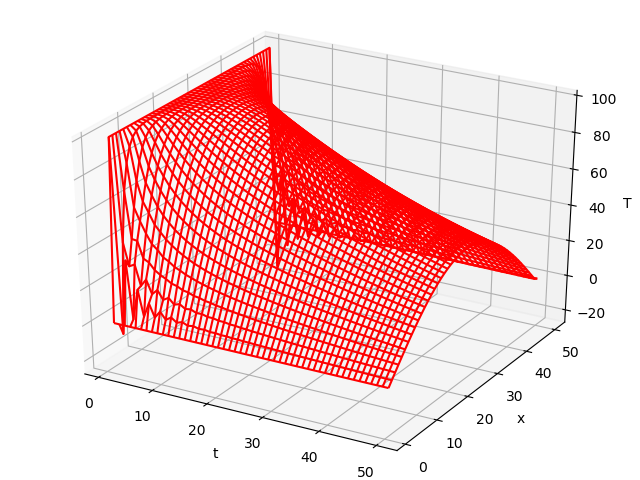

In [16]:
# HeatCrankNicolson.py, Notebook Version

import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D ;

Max = 51
n   = 50
m   = 50
Ta  = np.zeros(Max)
Tb  = np.zeros(Max)
Tc  = np.zeros(Max)
Td  = np.zeros(Max)
a   = np.zeros(Max)
b   = np.zeros(Max)
c   = np.zeros(Max)
d   = np.zeros(Max)
x   = np.zeros(Max)
t   = np.zeros((Max, Max))

def Tridiag(a, d, c, b, Ta, Td, Tc, Tb, x, n):                # Define Tridiag method
    h = np.zeros(Max)
    p = np.zeros(Max)
    for i in range(1,n+1):
        a[i] = Ta[i]
        b[i] = Tb[i]
        c[i] = Tc[i]
        d[i] = Td[i]
    h[1] = c[1]/d[1]
    p[1] = b[1]/d[1]
    for i in range(2,n+1):
        h[i] = c[i] / (d[i]-a[i]*h[i-1])
        p[i] = (b[i] - a[i]*p[i-1]) / (d[i]-a[i]*h[i-1])
    x[n] = p[n]
    for i in range( n - 1, 1,-1 ): x[i] = p[i] - h[i]*x[i+1]

width = 1.0
height = 0.1
ct = 1.0
for i in range(0, n):   t[i,0] = 0.0                                     # Initialize
for i in range( 1, m):  t[0][i] = 0.0
h  = width  / ( n - 1 )                            # Compute step sizes and constants
k  = height / ( m - 1 )
r  = ct * ct * k / ( h * h )

for j in range(1,m+1):
    t[0,j] = 0.                 # boundary condition: cold reservoirs
    t[n,j] = 0. 
for i in range( 2, n):   
    t[i][1] = np.sin( np.pi * h *i)   # sin func initial condition
    #at[i][1] = 100.             # hot bar initial condition

for i in range(1, n+1):  
    Td[i] = 2. + 2./r
Td[1] = 1.
Td[n] = 1.

for i in range(1,n ): 
    Ta[i] = -1.0
    Tc[i] = -1.0
Ta[n-1] = 0.0
Tc[1] = 0.0
Tb[1] = 0.0
Tb[n] = 0.0

for j in range(2,m+1):
    for i in range(2,n): 
        Tb[i] = t[i-1][j-1] + t[i+1][j-1] + (2/r-2) * t[i][j-1]
    Tridiag(a, d, c, b, Ta, Td, Tc, Tb, x, n)                        # Solve system
    for i in range(1, n+1):  
        t[i][j] = x[i]
print("Finished")
x = list(range(1, m+1))                                          # Plot every other x point
y = list(range(1, n+1))                                               # every other y point
X, Y = plt.meshgrid(x,y)               

def functz(t):                                           # Function returns potential
    z = t[X, Y]                 
    return z
Z = functz(t)                          
fig = plt.figure()                                                      # Create figure
ax = Axes3D(fig)                                                      # plots axes
ax.plot_wireframe(Y, X, Z, color= 'r')                                # red wireframe
ax.set_xlabel('t')                                                       # label axes
ax.set_ylabel('x')
ax.set_zlabel('T')
plt.show()             

Wow -- that was really fast!
If we are bold enough to solve the matrix in one shot, the performance benefit can be substantial.

# Coda: "Econophysics"

The hyperbolic equation that we encounter as the heat equation or diffusion equation also has applications in finance.

The [Black-Scholes pricing model for derivatives](https://en.wikipedia.org/wiki/Black–Scholes_equation) assumes that the price of a put option $V$ on a stock price $S$ follows

$$\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS \frac{\partial V}{\partial S} - rV = 0$$

where $S$ is the stock price at maturity time (expiration time), $t$ is the time until maturity, $r$ is the risk-free interest rate, and $\sigma$ is the volatility measured in the historical price fluctuations.

This equation can be used to find the correct pricing for the options, develop appropriate hedging strategy, and take advantage of mistakes/uncertainty in the market pricing.
The last action is known as arbitrage.

Further reading:
* G.G. Szpiro, *Pricing the future : finance, physics, and the 300-year journey to the Black-Scholes equation*, New York : Basic Books, 2011.
* K. in 't Hout, *Numerical Partial Differential Equations in Finance Explained*, Palgrave Macmillan, 2017.
* F. Black and M. Scholes,  "The Pricing of Options and Corporate Liabilities," Journal of Political Economy 81, no. 3 (1973): 637-654.
* R. C. Merton, "Theory of Rational Option Pricing," The Bell Journal of Economics and Management Science, Vol. 4, No. 1 (1973), pp. 141-183.